# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

print(phos)

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)
#print(len(all_proteins))
#print(all_proteins)

idx   AAAS-S495  AAAS-S541  AAAS-Y485  AACS-S618  AAED1-S12  AAGAB-S310  \
S001        NaN        NaN        NaN    -0.8810    -1.8100         NaN   
S002        NaN        NaN        NaN        NaN     0.0840         NaN   
S003   -0.20200        NaN        NaN        NaN    -1.8800         NaN   
S004    0.25000        NaN        NaN        NaN        NaN         NaN   
S005   -0.00200        NaN     -0.407        NaN        NaN         NaN   
S006    0.55600    -0.0461        NaN        NaN     0.9410         NaN   
S007        NaN        NaN        NaN        NaN     0.0796         NaN   
S008    0.30000        NaN        NaN    -0.3710    -1.1400         NaN   
S009    0.49000        NaN        NaN        NaN        NaN         NaN   
S010   -0.23100     0.0108        NaN        NaN     0.2420         NaN   
S011    0.26800        NaN        NaN        NaN    -0.1120         NaN   
S012   -0.06200        NaN        NaN     1.8600    -1.4000         NaN   
S013   -1.49000        Na

## t-test for effects of all mutations combined
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

### List of interacting proteins (according to STRING and Uniprot)

In [4]:
#Build the protein list; this may have only a single protein if desired
#protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']
protList = all_proteins[0:5000]

In [5]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[:100]
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [7]:
print(significant_proteins)
print(significant_pvals)

[]
[]


### Test for phosphorylation levels (mutation in any gene with phosphorylation of any protein)

In [8]:
#List of proteins (will test all phosphorylation sites on these proteins)
phosProtList = protList

In [9]:
sites = phos.columns
p_values = []
site_names = []

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'

print(p_values)
print(site_names)

sum = 0
for p in p_values:
    sum += p
avg = sum/len(p_values)

print("AVG p_val = ", avg)
        


[0.003796809670252839, 0.0704277325010654, 0.11960909111590355, 0.21466140885869223, 0.0009754227732282194, 0.27378415742134166, 0.09226101031620554, 0.532013635840291, 0.9154875299341083, 0.053936760757396056, 0.26922860654747677, 0.63428153421527, 0.7539785451895322, 0.844259978172367, 0.6268333803109642, 0.03867096194170425, 0.8166423595910417, 0.4079474423895876, 0.07575757536390328, 0.9459424485210043, 0.06407582230643188, 0.028835895790093952, 0.015150074525599848, 0.06785833998543087, 0.008067181394766977, 0.04942433751881339, 0.5561737099997661, 0.7225904691007914, 0.4650477611692434, 0.3329030732358248, 0.18682437340196792, 0.5714053858204541, 0.02615392491241445, 0.025724335379108308, 0.950608143886081, 0.3466899394822489, 0.3235344587872271, 0.06278412990486168, 0.30909032581028706, 0.2054103123240018, 0.03420597069241006, 0.49638696371303226, 0.11351333227292397, 0.37101167945618824, 0.5712040149217671, 0.06509033080667391, 0.4048668994696524, 0.14390435205187546, 0.0089611

### Seeing significance of P values using bonferroni correction

In [14]:
threshold_pval = .05/len(2*site_names)
print("threshold_pval: ", threshold_pval)
bonferonni_corrected_pvals = list()
bonferonni_sig_sites = list()
for ind in range(0, len(p_values)):
    if p_values[ind] <= threshold_pval:
        bonferonni_corrected_pvals.append(p_values[ind])
        bonferonni_sig_sites.append(site_names[ind])
        

        
bf_significant_vals = dict(zip(bonferonni_sig_sites, bonferonni_corrected_pvals))

threshold_pval:  5.286082801200998e-07


### Print signifcant p-values

In [15]:
print("\nSignificant P-values from Bonferroni: ", bonferonni_corrected_pvals)
print("\nSignificant Sites from Bonferroni: ", bonferonni_sig_sites)
print("\nSignificant values: ", bf_significant_vals)


Significant P-values from Bonferroni:  [5.498611238582909e-08, 2.8485316766016553e-07, 2.2505885402871095e-07, 1.6205841018425485e-07, 1.3708579177560915e-08, 2.767593594161629e-07, 5.502644062777942e-08, 1.9288016516412425e-08, 3.3425679957238745e-07, 4.403072547454285e-07, 2.0898925251561834e-07, 3.3045370792446175e-08, 1.9288016516412425e-08, 3.3425679957238745e-07, 4.403072547454285e-07, 2.0898925251561834e-07, 3.3045370792446175e-08, 3.917724263221153e-07, 2.5118737537977677e-07, 1.7654663022118694e-08, 2.1137840430720068e-07, 4.013333847930438e-09, 1.2785903810683652e-07, 3.3936904760010647e-07, 5.669363587791693e-09, 6.614014038405697e-08, 3.5902575982506184e-07, 4.5117313586733856e-08, 2.693454562963779e-07, 1.2785903810683652e-07, 3.3936904760010647e-07, 1.2785903810683652e-07, 3.3936904760010647e-07, 3.200133729361071e-08, 1.2205501701833273e-07, 5.119012509363846e-07, 2.2355184292170284e-08, 5.040212194350438e-07, 2.479278557099181e-08, 4.5117313586733856e-08, 1.16019421605

### Use FDR Correction

In [16]:
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]
significant_vals = dict(zip(significant_sites, significant_pvalues))


print("\nSignificant P-vals (FDR): ", significant_pvalues)
print("\nSignificant sites (FDR): ", significant_sites)
print("\nSignificant values (FDR): ", significant_vals)


Significant P-vals (FDR):  [0.03781936 0.01505602 0.04833431 ... 0.0349186  0.02631622 0.02631622]

Significant sites (FDR):  ['AAAS-S495' 'AAED1-S12' 'ABCC1-S919' ... 'LGALS1-S39' 'LGALS3BP-S444'
 'LGALS3BP-S444']

Significant values (FDR):  {'AAAS-S495': 0.03781935900272489, 'AAED1-S12': 0.015056019790161686, 'ABCC1-S919': 0.048334306905212204, 'ABCC1-S921': 0.02092208784252581, 'ABCF1-S166': 0.009697716213690139, 'ABCF1-S22': 0.006168058268734647, 'ABCF3-S157': 0.017409312999242647, 'ABI1-S216': 0.02345743241121096, 'ABI1-S225': 0.03170158308699769, 'ABI1-T200': 0.0078049485721987865, 'ABI2-S183': 0.01010269740374637, 'ABI2-S233': 0.008445128617810832, 'ABI2-S368': 0.00021369302347592562, 'ABL1-S199': 0.03745909016052993, 'ABL1-S824': 0.010312124046021548, 'ABL1-S828': 0.0008580087652804789, 'ABL1-T798': 0.005289991497866969, 'ABL1-Y204': 0.02943406646483269, 'ABLIM1-S367': 0.0014689045968014904, 'ABLIM1-S586': 0.03504930508520697, 'ABLIM1-S587': 0.016379617646621155, 'ABLIM2-S279'

### Plot phosphorylation levels and gene mutation
<b>Note:</b> There may be fewer data points due to NA values

INDEX MIN:  669  PVAL:  2.4375171047365483e-05
SIGNIFICANT SITES LENGTH:  5483
      AP3B2-S272           Mutation Patient_Type
S001     -0.8900  Missense_Mutation        Tumor
S002     -1.3600           Wildtype        Tumor
S003     -0.0993  Missense_Mutation        Tumor
S004     -1.1300           Wildtype        Tumor
S005         NaN           Wildtype        Tumor
S006      0.8250           Wildtype        Tumor
S007     -1.2000           Wildtype        Tumor
S008     -2.5800           Wildtype        Tumor
S009      0.7420  Missense_Mutation        Tumor
S010     -1.4500  Missense_Mutation        Tumor
S011     -1.1600           Wildtype        Tumor
S012     -4.2300  Missense_Mutation        Tumor
S013      0.0251           Wildtype        Tumor
S014     -1.9800  Missense_Mutation        Tumor
S015      0.1590           Wildtype        Tumor
S016      0.6640           Wildtype        Tumor
S017     -1.1800           Wildtype        Tumor
S018     -1.9000  Missense_Mutation    

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

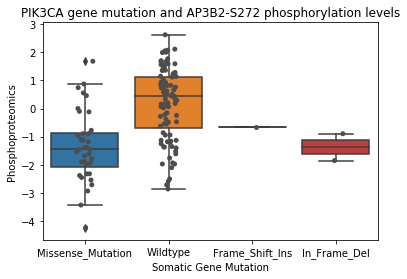

In [17]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above

index_min = significant_pvalues.tolist().index(min(significant_pvalues))
print("INDEX MIN: ", index_min, " PVAL: ", significant_pvalues[index_min])
gene = 'PIK3CA'
site = significant_sites[index_min]
print("SIGNIFICANT SITES LENGTH: ", len(significant_sites))

#print(somatic_mutations)

#Build the dataframe for plotting
#genedf = somatic_mutations[gene].to_frame()
genedf = CPTAC.compare_mutations(phos, site, gene)

print(genedf)
#sites = phos.filter(regex=site)
#genedf = genedf.add(sites, fill_value=0)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")